In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

## Read Data

In [101]:
train_data = pd.read_csv("cs-training.csv")

## Analyze data
- See the last section for the code
- From the preliminary analysis, data is very imbalanced, positive cases are only ~6.68%. ensemble or boosting method should be able to help overcome this issue. 
- We will evaluate: RandomForestClassifier, XGBClassifier and LogisticRegression
- For columns ['NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome'], the ranges of the data are very large. Since the agorithm we use can take into account the different in the range of the data by using coef, we can ignore this issue
- For ouliers, using Boxplots to detect the outliners, we find that the number of outliners are more many (~10), so we can ignore the outliners. This also helps to increase the variance of our models

## Preprocess data

In [102]:
def pre_process_data(df):
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.fillna(0, inplace=True)
    col_to_scale = ['NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome']

In [103]:
pre_process_data(train_data)

## Evaluate model

RandomForestClassifier and XGBClassifier give almost the same result. We will use RandomForestClassifier to train and predict the test data

In [104]:
x_train, x_test, y_train, y_test = train_test_split(train_data.iloc[:,1:],train_data.iloc[:,0], test_size=0.25, random_state=0)

In [105]:
learning_models = {
    "RandomForestClassifier":RandomForestClassifier(n_estimators= 100, min_samples_leaf= 100, max_depth= 50),
    "XGBClassifier": XGBClassifier(),
    "LogisticRegression": LogisticRegression(max_iter = 1000, solver='liblinear')
}

for model_type in learning_models:
    print(model_type)
    model = learning_models[model_type]
    model.fit(x_train, y_train)
    y_predict = model.predict_proba(x_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    print("auc: ",auc(fpr,tpr))

RandomForestClassifier
auc:  0.8584517460324843
XGBClassifier
auc:  0.851385585473683
LogisticRegression
auc:  0.6946218687451413


## Train data

In [106]:
model = RandomForestClassifier(n_estimators= 100, min_samples_leaf= 100, max_depth= 50)
model.fit(train_data.iloc[:,1:],train_data.iloc[:,0])

RandomForestClassifier(max_depth=50, min_samples_leaf=100)

## Predict test data

In [107]:
test_data = pd.read_csv("cs-test.csv")
pre_process_data(test_data)

In [108]:
## output test result
predicted_score = model.predict_proba(test_data.iloc[:,1:])[:,1]
ids = np.arange(1,101504)
result = pd.DataFrame( {'Id': ids, 'Probability': predicted_score})
result.to_csv("credit_score_prediction.csv", index=False)

## Analyze data

In [21]:
print(train_data.shape)
train_data.head()

(150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [13]:
# find the distribution of positive data. There are 6.68% positive data 
# -> data is very imbalance 
total_data = train_data.shape[0]
positive_data = train_data[train_data["SeriousDlqin2yrs"] == 1].shape[0]
print("percentage of positive data:",str(positive_data/total_data*100))

percentage of positive data: 6.683999999999999


In [22]:
print(train_data.isna().sum())
## -> MonthlyIncome and NumberOfDependents columns have nan values, we will replace nan value 
## with -1

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [23]:
## see the range of of column
train_data.max(axis=0) - train_data.min(axis=0)
## -> the range of RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome are very large
## compared with values of other columns, we will appply logs on the values of these column

Unnamed: 0                               149999.0
SeriousDlqin2yrs                              1.0
RevolvingUtilizationOfUnsecuredLines      50708.0
age                                         109.0
NumberOfTime30-59DaysPastDueNotWorse         98.0
DebtRatio                                329664.0
MonthlyIncome                           3008750.0
NumberOfOpenCreditLinesAndLoans              58.0
NumberOfTimes90DaysLate                      98.0
NumberRealEstateLoansOrLines                 54.0
NumberOfTime60-89DaysPastDueNotWorse         98.0
NumberOfDependents                           20.0
dtype: float64

(16, 12)


/Users/i347637/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


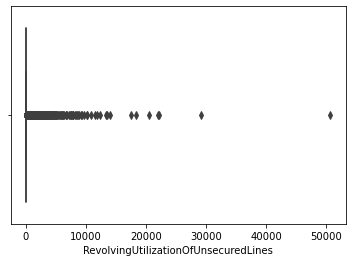

In [35]:
## detect outliner
sns.boxplot(train_data["RevolvingUtilizationOfUnsecuredLines"])
print(train_data[train_data["RevolvingUtilizationOfUnsecuredLines"]>10000].shape)

(12, 12)


/Users/i347637/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


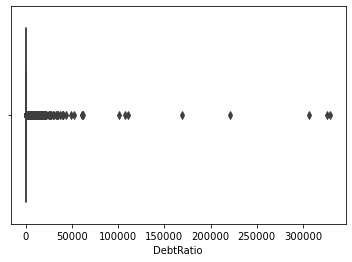

In [34]:
sns.boxplot(train_data["DebtRatio"])
print(train_data[train_data["DebtRatio"]>50000].shape)

(12, 12)


/Users/i347637/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


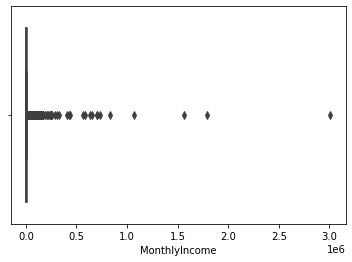

In [36]:
sns.boxplot(train_data["MonthlyIncome"])
print(train_data[train_data["MonthlyIncome"]>500000].shape)